# Using ICA to reduce artefacts

This section will show how to use an independent component analysis (ICA) approach to suppress ocular and cardiac artefacts. This will be done by first performing an ICA decomposition of the data after which the components reflecting the artefacts are identified manually. As a last step the artefact components are 'projected out'.

## Preparation

Important the relevant Python modules:

In [16]:
# mount the drive (you'll have to click through the popup to allow it)

from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install openneuro-py
!pip install --upgrade mne-bids[full]
!pip install ipympl  # for the widgets in ipynb

clear_output()  # just clear everything because the output is gross and unnecessary

In [5]:
import os.path as op
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne_bids import BIDSPath, read_raw_bids
from mne.preprocessing import ICA

### File overview
The chapter relies on the input files (embedded in the BIDS structure):
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif
~~~
and generates the output files:
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif
~~~

Set the local paths to the data:

In [8]:
subject = 'CB069'
session = '1'
task = 'dur'  # name of the task
run = '01'  # we have two runs for this subject, let's look at run = 1
meg_suffix = 'meg'
ann_suffix = 'ann'
ica_suffix = 'ica'

# bids_path = BIDSPath(subject=subject, session=session, task=task, run=run, suffix=sss_suffix, root=deriv_root)

# deriv_path = BIDSPath(subject=subject, session=session, datatype='meg',
#             task=task, run=run, suffix='meg', root=deriv_root).mkdir()
bids_root = 'drive/MyDrive/GripS MEG/Data/COGITATE/'  # for other people the path is likely under SharedDrive
deriv_root = op.join(bids_root, 'derivatives/preprocessing')  # output path

bids_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=ann_suffix,
            root=deriv_root, extension='.fif', check=False)

deriv_fname = bids_path.basename.replace(ann_suffix, ica_suffix)
deriv_file_1 = op.join(bids_path.directory, deriv_fname)
deriv_file_2 = deriv_file_1.replace('run-01', 'run-02')
deriv_file_3 = deriv_file_1.replace('run-01', 'run-03')
deriv_file_4 = deriv_file_1.replace('run-01', 'run-04')
deriv_file_5 = deriv_file_1.replace('run-01', 'run-05')
deriv_files = [deriv_file_1, deriv_file_2,deriv_file_3,deriv_file_4,deriv_file_5]

In [9]:
deriv_files

['drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_ica.fif',
 'drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-02_ica.fif',
 'drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-03_ica.fif',
 'drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-04_ica.fif',
 'drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-05_ica.fif']

### Resampling and filtering of the raw data
In order to do the ICA decomposition efficiently and keep all sub-data sets in memory, we will first down-sample the data. We will use the datasets in which SSS was applied and annotations noted. We will then apply the resample function to downsample the data to 200 Hz and then apply a 1 - 40 Hz bandpass filter. The 1 Hz highpass is important for removing slow drifts which otherwise would make the ICA decomposition less efficient. After these operation the data sets are concatenated such that the ICA can be performed on the data sets in one hit.

In [12]:
for subfile in range(5):
    bids_path=bids_path.update(run=f"{subfile+1:02d}")
    raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
    raw_resmpl = raw.copy().pick('meg')
    raw_resmpl.resample(200) # dowsample to 200 Hz
    raw_resmpl.filter(1, 40) # band-pass filtert from 1 to 40 Hz

    # I think this block of code is ok but scares me
    if subfile == 0 : raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl])
    else : raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl_all, raw_resmpl], on_mismatch='ignore')

del raw_resmpl

Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_ann.fif...


<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: This filename (drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)


    Range : 9000 ... 511999 =      9.000 ...   511.999 secs
Ready.
Reading 0 ... 502999  =      0.000 ...   502.999 secs...


<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any events.tsv associated with sub-CB069_ses-1_task-dur_run-01.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any channels.tsv associated with sub-CB069_ses-1_task-dur_run-01.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any meg.json associated with sub-CB069_ses-1_task-dur_run-01.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*meg.json"
  raw = read_raw_bids(bids_path=bids_path, extra_p

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.7s


Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-02_ann.fif...


<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: This filename (drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-02_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)


    Range : 9000 ... 812999 =      9.000 ...   812.999 secs
Ready.
Reading 0 ... 803999  =      0.000 ...   803.999 secs...


<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any events.tsv associated with sub-CB069_ses-1_task-dur_run-02.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any channels.tsv associated with sub-CB069_ses-1_task-dur_run-02.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any meg.json associated with sub-CB069_ses-1_task-dur_run-02.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*meg.json"
  raw = read_raw_bids(bids_path=bids_path, extra_p

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.9s


Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-03_ann.fif...


<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: This filename (drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-03_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)


    Range : 8000 ... 809999 =      8.000 ...   809.999 secs
Ready.
Reading 0 ... 801999  =      0.000 ...   801.999 secs...


<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any events.tsv associated with sub-CB069_ses-1_task-dur_run-03.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any channels.tsv associated with sub-CB069_ses-1_task-dur_run-03.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any meg.json associated with sub-CB069_ses-1_task-dur_run-03.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*meg.json"
  raw = read_raw_bids(bids_path=bids_path, extra_p

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    1.0s


Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-04_ann.fif...


<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: This filename (drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-04_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)


    Range : 8000 ... 815999 =      8.000 ...   815.999 secs
Ready.
Reading 0 ... 807999  =      0.000 ...   807.999 secs...


<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any events.tsv associated with sub-CB069_ses-1_task-dur_run-04.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any channels.tsv associated with sub-CB069_ses-1_task-dur_run-04.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any meg.json associated with sub-CB069_ses-1_task-dur_run-04.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*meg.json"
  raw = read_raw_bids(bids_path=bids_path, extra_p

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.5s


Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-05_ann.fif...


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.9s
<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: This filename (drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-05_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)


    Range : 9000 ... 778999 =      9.000 ...   778.999 secs
Ready.
Reading 0 ... 769999  =      0.000 ...   769.999 secs...


<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any events.tsv associated with sub-CB069_ses-1_task-dur_run-05.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any channels.tsv associated with sub-CB069_ses-1_task-dur_run-05.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
<ipython-input-12-6d2ad1a09ef7>:3: RuntimeWarning: Did not find any meg.json associated with sub-CB069_ses-1_task-dur_run-05.

The search_str was "drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/**/meg/sub-CB069_ses-1*meg.json"
  raw = read_raw_bids(bids_path=bids_path, extra_p

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    1.0s


### Applying the ICA algorithm
Now we apply the ICA algorithm. We have chosen for the *fastica* approach as it is well established and widely used. However, other ICA methods are available in MNE-Python. To expedite the computation, we have chosen to restric the ICA to the initial 30 components.

In [22]:
# for ICA we select enough components to encompass 99% of the variance in the data
ica = ICA(method='fastica', n_components=0.99, random_state=123, verbose=True)

ica.fit(raw_resmpl_all, verbose=True)

Fitting ICA to data using 306 channels (please be patient, this may take a while)
Omitting 2883 of 737400 (0.39%) samples, retaining 734517 (99.61%) samples.
Selecting by explained variance: 47 components
Fitting ICA took 82.0s.


<ICA | raw data decomposition, method: fastica (fit in 83 iterations on 734517 samples), 47 ICA components (306 PCA components available), channel types: mag, grad, no sources marked for exclusion>

### Identifying the ICA components reflecting the artefacts
To plot the examples for the time-traces of the ICA components use:

Creating RawArray with float64 data, n_channels=47, n_times=737400
    Range : 1800 ... 739199 =      9.000 ...  3695.995 secs
Ready.


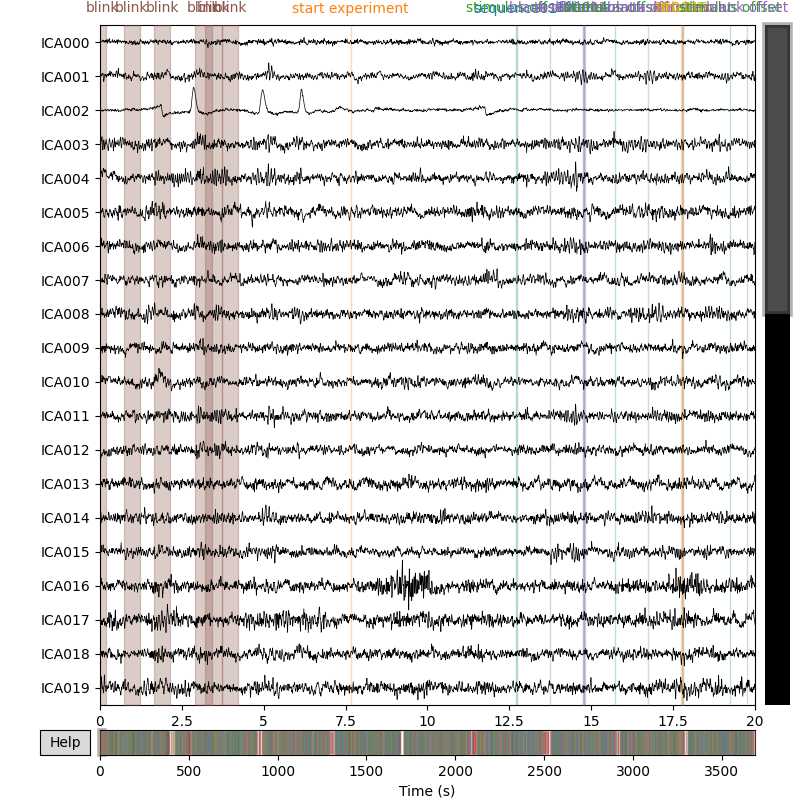

In [23]:
from google.colab import output
output.enable_custom_widget_manager()

%matplotlib widget
ica.plot_sources(raw_resmpl_all, title='ICA');

Use the left/right arrow-keys to scroll through the data and the up/down arrow-keys to scroll through the components. Right-click on the IC names to see the corrisponding topographies and other details.


When inspecting the traces, it is clear that ICA000 and ICA001 reflect eye-blinks as measured most strongly. Component ICA015 reflects saccades. Finally, ICA023 reflects the ECG.
This order of ICA components is specific to this data set and the seed (*random_state*) used for the ICA decomposition. For other data sets or using a different seed the components will come in a different order. Therefore the components associated with artefacts have to be identified manually.

**Question 1:** Estimate the frequency of the heart rate

**Question 2:** Identify the saccades in ICA015


To show the topographies of the each of the ICA components write:

In [25]:
%matplotlib widget
ica.plot_components();

Output hidden; open in https://colab.research.google.com to view.

In [11]:
[2,29,39,41]

[]

These plots show the topography associated with the magnetometers as they are more straightforward to interpret. The topography of ICA000 and ICA001 look like a classical eye-blink artefacts with strong activity over frontal left and right sensors of opposite polarity. The frontal negativity of ICA015 is associated with saccades. ICA023 looks like a typical ECG artefact as observed by the strong activity in the rim sensors stemming from the magnetic field circling the heart.

How many components should in general be removed? As a rule of thumb not more than a handful. Typically only remove components which clearly reflect a physiological artefact. Removing too many components might remove brain activity as well.

**Question 3:** Which component(s) might reflect the human alpha band activity? Base your argument both on the traces and topographies.


### Attenuating  the artefacts by applying the projections
Now that we have detected the ICA components associated with ocular and cardiac artefacts, we have to 'project out' them. This will be done by applying the ICA projections generated by *ica.exclude* to the original raw data which will be loaded again by looping over the sub-files. After the ICA projections have been applied (*ica.apply*) the data will be saved.

In [26]:
# Set the 4 components to exclude
ica.exclude = [2,29,39,41]

# Loop over the subfiles
for subfile in range(5):
    bids_path=bids_path.update(run=f"{subfile+1:02d}")

    raw_ica = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
    ica.apply(raw_ica)

    raw_ica.notch_filter(freqs=[50, 100], picks='meg')
    raw_ica.filter(l_freq=1, h_freq=90, picks='meg')
    raw_ica.save(deriv_files[subfile], overwrite=True)

Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_ann.fif...
    Range : 9000 ... 511999 =      9.000 ...   511.999 secs
Ready.
Reading 0 ... 502999  =      0.000 ...   502.999 secs...
Applying ICA to Raw instance
    Transforming to ICA space (47 components)
    Zeroing out 4 ICA components
    Projecting back using 306 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    4.5s


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.9s


Overwriting existing file.
Writing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_ica.fif


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    3.6s


Closing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_ica.fif
[done]
Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-02_ann.fif...
    Range : 9000 ... 812999 =      9.000 ...   812.999 secs
Ready.
Reading 0 ... 803999  =      0.000 ...   803.999 secs...
Applying ICA to Raw instance
    Transforming to ICA space (47 components)
    Zeroing out 4 ICA components
    Projecting back using 306 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    5.9s


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.1s


Overwriting existing file.


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    5.5s


Writing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-02_ica.fif
Closing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-02_ica.fif
[done]
Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-03_ann.fif...
    Range : 8000 ... 809999 =      8.000 ...   809.999 secs
Ready.
Reading 0 ... 801999  =      0.000 ...   801.999 secs...
Applying ICA to Raw instance
    Transforming to ICA space (47 components)
    Zeroing out 4 ICA components
    Projecting back using 306 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.1s


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    5.6s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.8s


Overwriting existing file.


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    5.1s


Writing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-03_ica.fif
Closing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-03_ica.fif
[done]
Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-04_ann.fif...
    Range : 8000 ... 815999 =      8.000 ...   815.999 secs
Ready.
Reading 0 ... 807999  =      0.000 ...   807.999 secs...
Applying ICA to Raw instance
    Transforming to ICA space (47 components)
    Zeroing out 4 ICA components
    Projecting back using 306 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    5.5s


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    5.2s


Overwriting existing file.
Writing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-04_ica.fif
Closing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-04_ica.fif
[done]
Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-05_ann.fif...
    Range : 9000 ... 778999 =      9.000 ...   778.999 secs
Ready.
Reading 0 ... 769999  =      0.000 ...   769.999 secs...
Applying ICA to Raw instance
    Transforming to ICA space (47 components)
    Zeroing out 4 ICA components
    Projecting back using 306 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    5.2s


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.9s


Overwriting existing file.
Writing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-05_ica.fif


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    5.2s


Closing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-05_ica.fif
[done]


## Plotting the data to check the artefact reduction

We will here examine some of the traces from one of the subfiles (#1) to demonstrate the artefact reduction.

Define a few frontal magnetometers to examine and include the EOG sensors:

In [18]:
chs = ['MEG0311', 'MEG0121', 'MEG1211', 'MEG1411']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]

Then plot the data before the ICA projections were applied. Use the arrow button to scroll through the trials.

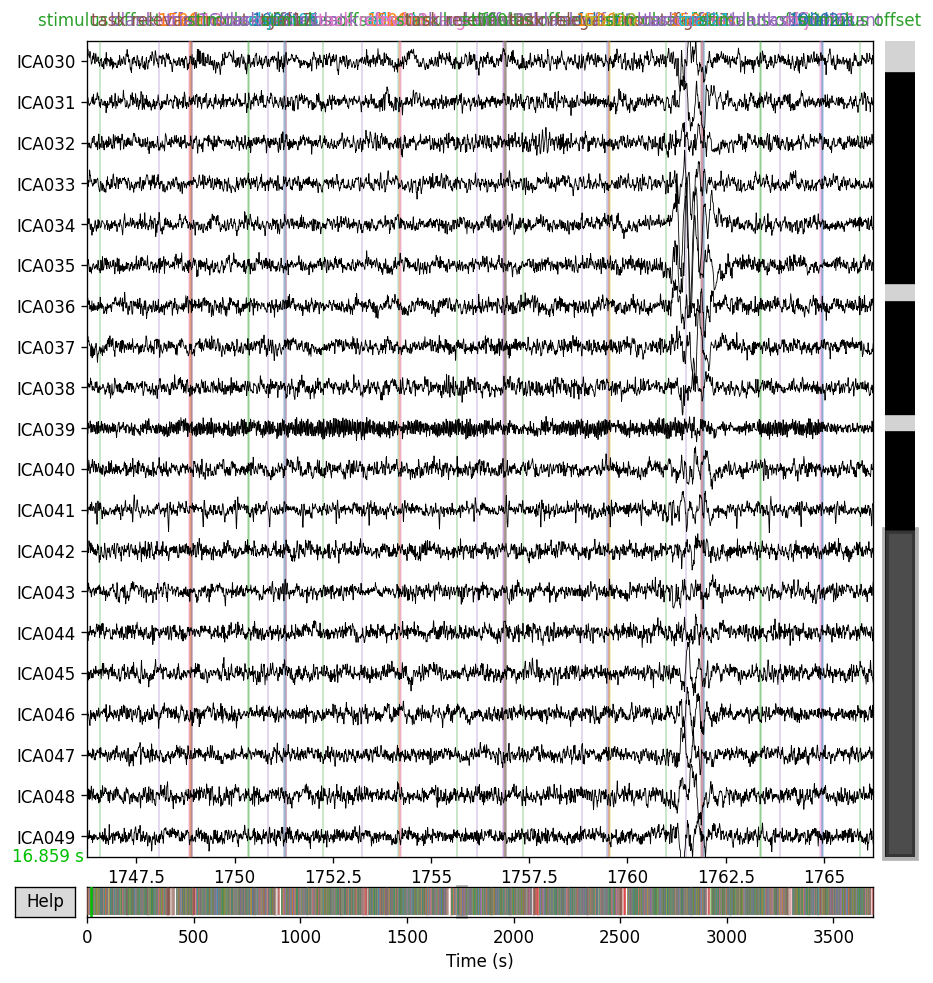

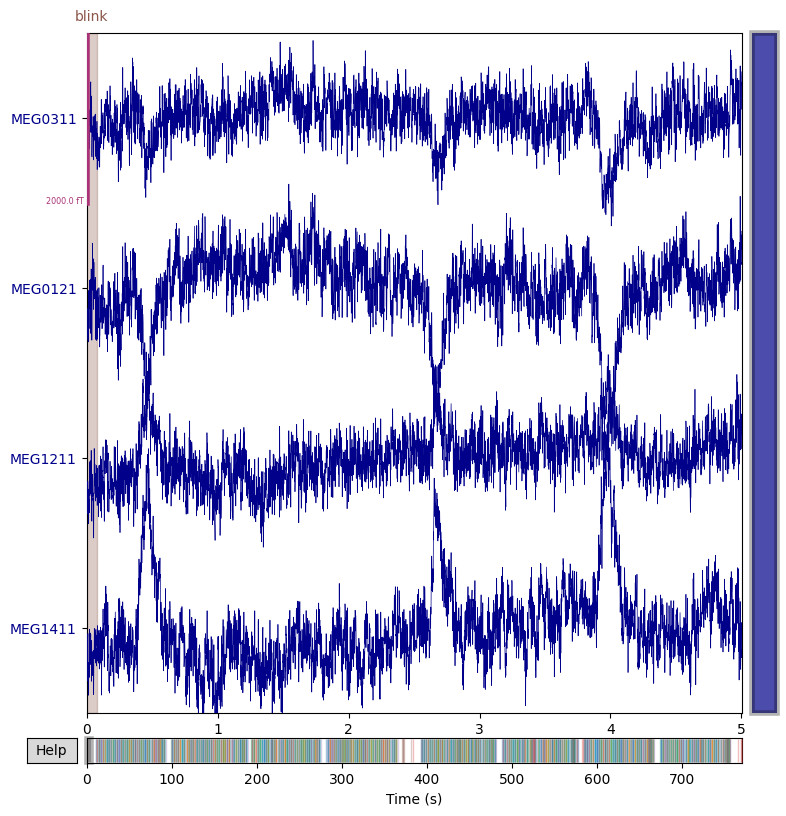

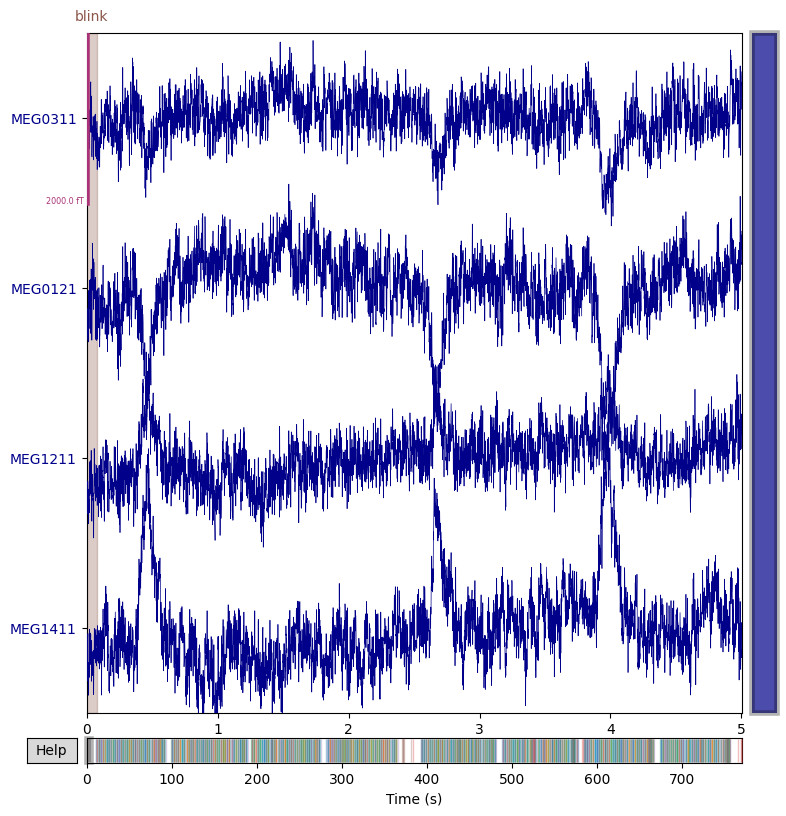

In [19]:
%matplotlib inline
raw.plot(order=chan_idxs, duration=5)

The plot above shows the raw traces before the application of the ICA projections. Note the ocular artefacts in the MEG data at e.g. ~1 sec.

Then plot the same traces after the application of the ICA projections:

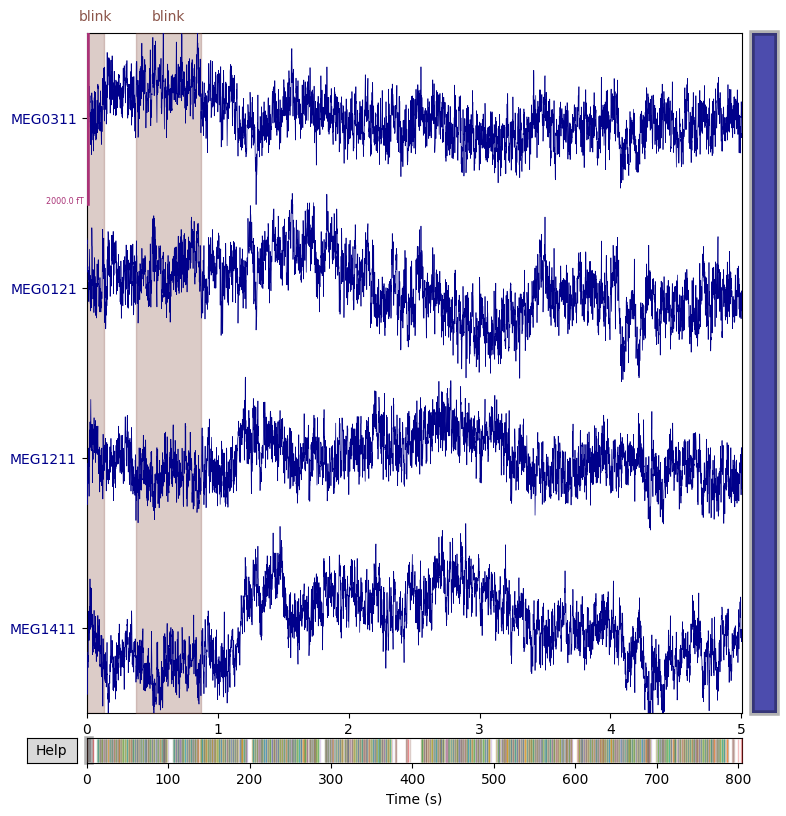

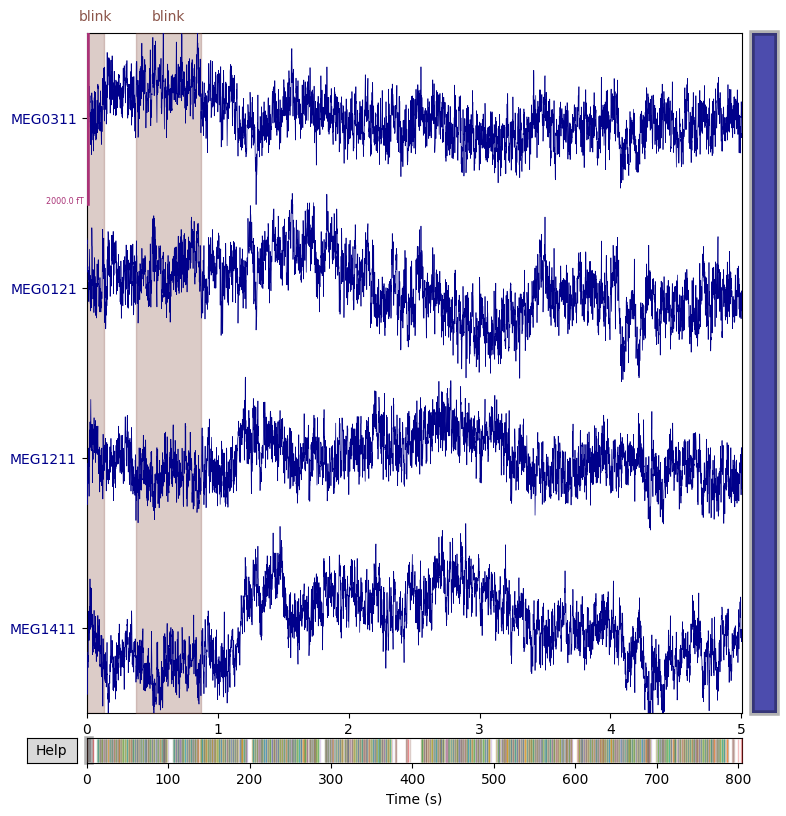

In [20]:
%matplotlib inline
raw_ica.plot(order=chan_idxs, duration=5)

As seen in the plot above, the ocular artefacts are clearly reduced.

## Preregistration and publication

Example text:  
"The data were down sampled to 200 Hz prior to Independent Component Analysis (ICA) and bandpass filtered at 1 – 40 Hz. Next the fastICA algorithm  (Hyvärinen and Oja, 2000) was applied to the segmented data as implemented in MNE Python. Components containing cardiac artefacts and eyeblinks (identified in time course and topographies of the ICA components) were removed in each subject (3 – 5 over subjects) in the raw unfiltered data. "



## References

* Hyvärinen A, Oja E. (2002) Independent component analysis: algorithms and applications. Neural Netw. 13(4-5):411-30. doi: 10.1016/s0893-6080(00)00026-5.